In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-06 13:37:54.227665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 13:37:55.237902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
FEATURE_COLS = test_df.columns[1:].tolist()



In [3]:
# sd_columns = [col for col in train_df.columns if col.endswith('_sd')]
# train_df.drop(columns=sd_columns, inplace=True)


In [4]:

# train_images_path = './data/train_images/'
# test_images_path = './data/test_images/'    

# train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
# # test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))

# train_df.head()


In [23]:



def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [6]:
# plot_data(train_df, mean_columns)

# for column in mean_columns:
#     upper_quantile = train_df[column].quantile(0.99)  
#     train_df = train_df[(train_df[column] < upper_quantile)]
#     train_df = train_df[(train_df[column] > 0)]    

# plot_data(train_df, mean_columns)

In [7]:
# train_df[mean_columns].describe()

In [8]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for i, trait in enumerate(mean_columns):

#     # Determine the bin edges dynamically based on the distribution of traits
#     bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
#     train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# # Concatenate the bins into a final bin
# train_df["final_bin"] = (
#     train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
#     .astype(str)
#     .agg("".join, axis=1)
# )

# # Perform the stratified split using final bin
# train_df = train_df.reset_index(drop=True)
# for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
#     train_df.loc[valid_idx, "fold"] = fold



In [9]:

# # Taking sqrt as it is a better scaling technique for the data distribution
# train_df[mean_columns] = np.sqrt(train_df[mean_columns])



In [10]:

# batch_size = 32

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg')
# base_model.trainable = False

# def load_and_preprocess_image(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (480, 480))
#     return img


# def extract_features_batch(image_paths):
#     img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
#     features = base_model.predict(img_batch)        
#     return features

# image_paths = train_df['image_path'].values

# features_list = []
# j = 0
# for i in range(0, len(image_paths), batch_size):
#     batch_paths = image_paths[i:i+batch_size]
#     batch_features = extract_features_batch(batch_paths)
#     features_list.append(batch_features)
#     j += 1
#     if j % 30 == 0:
#         tf.keras.backend.clear_session()
#         gc.collect()
#         print(f'Clearing session')

# all_features = np.vstack(features_list)
# train_df['features_avg'] = list(all_features)




In [11]:
# print(train_df.shape)
# train_df.head()

In [12]:

# batch_size = 32

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max')
# base_model.trainable = False

# def load_and_preprocess_image(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (480, 480))
#     return img


# def extract_features_batch(image_paths):
#     img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
#     features = base_model.predict(img_batch)        
#     return features

# image_paths = train_df['image_path'].values

# features_list = []
# j = 0
# for i in range(0, len(image_paths), batch_size):
#     batch_paths = image_paths[i:i+batch_size]
#     batch_features = extract_features_batch(batch_paths)
#     features_list.append(batch_features)
#     j += 1
#     if j % 30 == 0:
#         tf.keras.backend.clear_session()
#         gc.collect()
#         print(f'Clearing session')

# all_features = np.vstack(features_list)
# train_df['features_max'] = list(all_features)




In [13]:
# print(train_df.shape)
# train_df.head()

In [14]:
# print(train_df.head(10))
# print(train_df.describe())
# print(train_df.info())

In [15]:
# train_df['features'] = train_df.apply(lambda x: np.concatenate([x['features_avg'], x['features_max']]), axis=1)

In [16]:
# print(train_df['features'].head())
# print(train_df['features'].iloc[0].shape)
# print(train_df.info())


In [17]:
import pickle

# Specify the file path to save the pickle file
pickle_file_path = './data/train_df.pickle'

# Save the train_df dataframe as a pickle file
# with open(pickle_file_path, 'wb') as f:
#     pickle.dump(train_df, f)


# # Load the train_df dataframe from the pickle file
with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    


In [18]:
print(train_df['fold'].value_counts())

scaler = StandardScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

with open('./data/scaler_tabufeatures_train.pickle', 'wb') as f:
    pickle.dump(scaler, f)


fold
0.0    10418
1.0    10417
3.0    10417
4.0    10417
2.0    10417
Name: count, dtype: int64
# Num Train: 41669 | Num Valid: 10417


/tmp/ipykernel_2982673/2236561408.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_2982673/2236561408.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [19]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
y_train = train_df[mean_columns].values

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
y_valid = valid_df[mean_columns].values



In [20]:
print(X_train_tab.shape)    
print(X_train_feat.shape)

(41669, 163)
(41669, 2560)


In [21]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,41669.000000,41669.000000,41669.000000,41669.000000,41669.000000,41669.000000
mean,0.713156,3.870202,1.308516,1.242981,3.165202,33.372093
std,0.099560,0.926959,1.104193,0.238211,4.547091,24.063668
min,0.083642,1.160749,0.054030,0.276618,0.013382,1.053010
25%,0.640683,3.300290,0.549702,1.084772,0.726465,15.971240
50%,0.710393,3.904812,0.824414,1.212863,1.518576,26.385379
75%,0.786418,4.428264,1.756299,1.378137,3.605314,44.783598
max,0.959328,6.975005,5.318439,2.048040,34.852008,143.667492


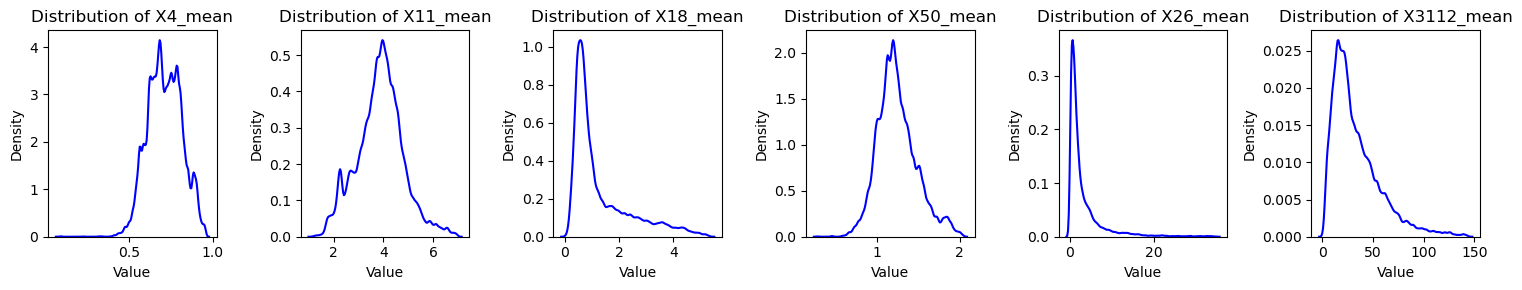

In [24]:
plot_data(train_df, mean_columns)

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from optuna.integration import TFKerasPruningCallback
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os





def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 


def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss


global current_delta
def create_model(trial):

    image_features_input = Input(shape=(X_train_feat.shape[1],), name='image_features_input')
    tabular_data_input = Input(shape=(X_train_tab.shape[1],), name='tabular_data_input')

    img_num_layers = trial.suggest_int('Imgage layers', 1, 2)
    max_img_units = 1024
    img_dense = image_features_input
    
    image_init = trial.suggest_categorical(f'Img_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_img = trial.suggest_categorical(f'Act_img', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_img = trial.suggest_float(f'Drop_img', 0.2, 0.7, step=0.1)
    batch_norm_img = trial.suggest_categorical(f'Img_BatchN', choices = [True, False])
    for i in range(img_num_layers):

        num_img_units = trial.suggest_int(f'Num_img_{i}', 256, max_img_units, log = True)        
        img_dense = Dense(num_img_units, activation=activation_img, kernel_initializer = image_init)(img_dense)
        if batch_norm_img:
            img_dense = layers.BatchNormalization()(img_dense)
        img_dense = Dropout(drop_img)(img_dense)
        max_img_units = min(max_img_units, num_img_units)


    tab_num_layers = trial.suggest_int('Tabular layers', 1, 2)
    max_tab_units = 1024   
    tab_dense = tabular_data_input
    tab_init = trial.suggest_categorical(f'Tab_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform',  'random_normal', 'random_uniform'])
    activation_tab = trial.suggest_categorical(f'Act_tab', choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_tab = trial.suggest_float(f'Drop_tab', 0.2, 0.7, step = 0.1)
    batch_norm_tab = trial.suggest_categorical(f'Tab_BatchN', choices = [True, False])
    for i in range(tab_num_layers):

        num_tab_units = trial.suggest_int(f'Num_tab_{i}', 256, max_tab_units, log = True)    
        tab_dense = Dense(num_tab_units, activation=activation_tab, kernel_initializer = tab_init)(tab_dense)
        if batch_norm_tab:
            tab_dense = layers.BatchNormalization()(tab_dense)
        tab_dense = Dropout(drop_tab)(tab_dense)

        max_tab_units = min(max_tab_units, num_tab_units)


    concatenated = Concatenate()([img_dense, tab_dense])
    com_num_layers = trial.suggest_int('Concat layers', 1, 2)
    max_com_units = 2048
    con_init = trial.suggest_categorical(f'Con_init', choices = ['glorot_uniform', 'he_normal', 'he_uniform', 'lecun_normal', 'lecun_uniform', 'random_normal', 'random_uniform'])
    activation_common = trial.suggest_categorical(f'Act_con',  choices = ['relu', 'tanh', 'selu', 'LeakyReLU', 'swish', 'elu'])
    drop_common = trial.suggest_float(f'Drop_con', 0.2, 0.7, step = 0.1)
    batch_norm_common = trial.suggest_categorical(f'Com_BatchN', [True, False])
    for i in range(com_num_layers):
        
        num_common_units = trial.suggest_int(f'Num_con_{i}', 256, max_com_units, log = True)
        concatenated = Dense(num_common_units, activation=activation_common, kernel_initializer = con_init)(concatenated)
        if batch_norm_common:
            concatenated = layers.BatchNormalization()(concatenated)
        concatenated = Dropout(drop_common)(concatenated)

        max_com_units = min(max_com_units, num_common_units)

    output = Dense(6, activation='relu')(concatenated)  
    model = Model(inputs=[image_features_input, tabular_data_input], outputs=output)
    
    
    # optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    # optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    
    # if optimizer_selected == 'adam':
    #     optimizer = optimizers.Adam()
    # elif optimizer_selected == 'rmsprop':
    #     optimizer = optimizers.RMSprop()
    # elif optimizer_selected == 'Nadam':
    #     optimizer = optimizers.Nadam()
    # elif optimizer_selected == 'Adagrad':
    #     optimizer = optimizers.Adagrad()
    # elif optimizer_selected == 'Adadelta':
    #     optimizer = optimizers.Adadelta()
    # else:
    #     optimizer = optimizers.Adamax()

    delta = trial.suggest_float('delta', 0.2, 2.0, step=0.1)
    global current_delta
    current_delta = delta
  
    model.compile(optimizer=optimizers.Adam(), loss=huber_loss_wrapper(delta), metrics=['mse','mae', r2_score])
    return model



def objective(trial):

    model = create_model(trial)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"./data/{study_name}_search_model.h5",            
            monitor='val_r2_score',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=0)


    callbacks = [
                 ReduceLROnPlateau('val_r2_score', patience=3, factor=0.5, mode = 'max'), 
                 TerminateOnNaN(),
                 model_checkpoint_callback,
                 TFKerasPruningCallback(trial, 'val_r2_score')]


    history = model.fit([X_train_feat, X_train_tab], y_train, validation_data=([X_valid_feat, X_valid_tab], y_valid), batch_size=512, epochs=50, callbacks=callbacks, verbose = 0)

    best_val_r2 = max(history.history['val_r2_score'])

    best_epoch = history.history['val_r2_score'].index(max(history.history['val_r2_score'])) + 1

    model.load_weights(f'./data/{study_name}_search_model.h5')
    preds = model.predict([X_valid_feat, X_valid_tab], verbose = 0)
    preds_2 = np.square(preds)
    y_valid_2 = np.square(y_valid)
    r2_score_sqrt = r2_score(y_valid_2, preds_2)

    if trial.number > 0:
        if r2_score_sqrt > study.best_value:

            print("*" * 50)
            print(f'Old best R2 : {study.best_value:.5f}')
            print(f'New best R2 : {r2_score_sqrt:.5f}')
            
            preds = model.predict([X_valid_feat, X_valid_tab])
            preds_2 = np.square(preds)
            y_valid_2 = np.square(y_valid)

            r2 = r2_score(y_valid_2, preds_2)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_2, preds_2)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_2, preds_2)
            huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            print(f'Last epoch Squared errors R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            
            model.load_weights(f'./data/{study_name}_search_model.h5')
            
            preds = model.predict([X_valid_feat, X_valid_tab])
            preds_2 = np.square(preds)
            y_valid_2 = np.square(y_valid)
            r2 = r2_score(y_valid_2, preds_2)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid_2, preds_2)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid_2, preds_2)
            huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid_2, preds_2)
            print(f'Best epoch squared R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')

            preds = model.predict([X_valid_feat, X_valid_tab])
            r2 = r2_score(y_valid, preds)
            mse  = tf.keras.losses.MeanSquaredError()(y_valid, preds)
            mae = tf.keras.losses.MeanAbsoluteError()(y_valid, preds)
            huberloss = tf.keras.losses.Huber(delta=current_delta)(y_valid, preds)
            print(f'Best epoch raw R2 : {r2:.5f}, MSE : {mse:.5f}, MAE : {mae:.5f}, huber_loss : {huberloss:.5f}')
            print(f'Best epoch : {best_epoch}')

            best_filename = f'./data/{study_name}_best_val_{r2_score_sqrt:.5f}_model.h5'
            if os.path.exists(best_filename):
                os.remove(best_filename)

            print(f'Saving model to {best_filename}')    
            model.save(best_filename)
            print("*" * 50)

    if os.path.exists(f'./data/{study_name}_search_model.h5'):
        os.remove(f'./data/{study_name}_search_model.h5')
            
    return r2_score_sqrt


study_name = '406_r2squretilla_relulopussa_adam_max_avg_fold_3'
num_random_trials = 20
num_tpe_trial = 0
search_time_max = 3600 * 12

study = optuna.create_study(direction='maximize',                            
                            study_name=study_name,
                            storage=f'sqlite:///406_sqrt_huber_adam_max_avg.db',
                            load_if_exists=True,
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10, interval_steps=5),
                            )

search_time_taken = 0
search_start = time.time()
round = 0

while search_time_taken < search_time_max:

    round_start = time.time()

    print(f'Starting study with {num_random_trials} random trials, round {round}')
    print(f'Search time so far taken : {timedelta(seconds=search_time_taken)}')
    print('-' * 50)
    study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) 
    study.optimize(objective, n_trials=num_random_trials)
    print(f'Time taken for random trials: {timedelta(seconds= (time.time() - round_start))}')
    print(f'Starting TPE {num_tpe_trial} trials...')    
    study.sampler = optuna.samplers.TPESampler(n_startup_trials=0, multivariate=True, warn_independent_sampling = False)
    study.optimize(objective, n_trials=num_tpe_trial)
    print(f'Time taken for one trial: {timedelta(seconds= (time.time() - round_start) / (num_random_trials + num_tpe_trial))}')    
    print(f'Time this round: {timedelta(seconds= time.time() - round_start)}')
    
    search_time_taken = time.time() - search_start
    round += 1

print(f'Search time total : {timedelta(seconds=time.time() - search_start)}')




[I 2024-04-06 13:39:54,103] Using an existing study with name '406_r2squretilla_relulopussa_max_avg_fold_3' instead of creating a new one.


/tmp/ipykernel_2982673/3096182566.py:225: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)


Starting study with 20 random trials, round 0
Search time so far taken : 0:00:00
--------------------------------------------------


In [ ]:

batch_size = 32

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch)        
    return features

image_paths = test_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
test_df['features_avg'] = list(all_features)




In [ ]:
print(test_df.shape)
print(test_df.head())


In [ ]:

batch_size = 32

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch)        
    return features

image_paths = test_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
test_df['features_max'] = list(all_features)




In [ ]:
print(test_df.shape)
print(test_df.head())


In [ ]:
test_df['features'] = test_df.apply(lambda x: np.concatenate([x['features_avg'], x['features_max']]), axis=1)

In [ ]:
print(test_df['features'].head())
print(test_df['features'].iloc[0].shape)
print(test_df.info())


In [ ]:
pickle_file_path = './data/test_df.pickle'

# # Save the train_df dataframe as a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(test_df, f)

# with open(pickle_file_path, 'rb') as f:
#     test_df = pickle.load(f)

test_df.head()

In [ ]:
print(test_df.columns)
print(FEATURE_COLS)
print(len(FEATURE_COLS))

print(train_df.columns)
print(train_df.shape)

In [ ]:

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0)) 

def huber_loss_wrapper(delta):
    def huber_loss(y_true, y_pred):
        return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
    return huber_loss




custom_objects = {"r2_score": r2_score, "huber_loss": huber_loss_wrapper(1.5)}


with open('./data/scaler_tabufeatures_train.pickle', 'rb') as f:
    scaler = pickle.load(f)


best_model_name = './data/405_huberia_fold_3_best_val_0.26317_model.h5'

best_model = tf.keras.models.load_model(f'{best_model_name}', custom_objects=custom_objects)



test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS].values)

submission_df = test_df[['id']].copy()

X_test_tab = test_df[FEATURE_COLS].values
X_test_feat = np.stack(test_df['features'].values) 

predictions = best_model.predict([X_test_feat, X_test_tab])
predictions = np.square(predictions)

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions

print(submission_df.head())
print(submission_df.shape)
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)
submission_df.head()




